In [13]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

tickers = ['NEM', 'RCL', 'MSI', 'NVDA', 'MSFT', 'AAPL']

start_date = '2015-01-01'
end_date = '2020-01-01'

data = yf.download(tickers = tickers, start = start_date, end = end_date)[['Open', 'Close', 'High', 'Low']]

prices = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_5010/402276002.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = tickers, start = start_date, end = end_date)[['Open', 'Close', 'High', 'Low']]
[*********************100%***********************]  6 of 6 completed


In [17]:
# rolling cointegration

window_size = 252
min_passes = 0.4
step = 21

candidate_pairs = []
cointegrated_pairs = []

category_prices = prices[tickers]

for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        candidate_pairs.append([tickers[i], tickers[j]])

for etf1, etf2 in candidate_pairs:
            
    df = category_prices[[etf1, etf2]].dropna()

    series1 = df.iloc[:, 0]
    series2 = df.iloc[:, 1]

    cointegrated_windows = 0
    total_windows = 0

    for start in range(0, len(df) - window_size + 1, step):
        end = start + window_size

        window_s1 = series1.iloc[start:end]
        window_s2 = series2.iloc[start:end]
                
        score, pvalue, _ = coint(window_s1, window_s2)
        total_windows += 1
                
        if pvalue < 0.1:
            cointegrated_windows += 1

    if cointegrated_windows / total_windows >= min_passes:
        cointegrated_pairs.append({'ETF1': etf1, 'ETF2': etf2, 'Pass %': cointegrated_windows / total_windows})
    print(f'ETF1: {etf1}, ETF2: {etf2}, Pass %: {cointegrated_windows / total_windows}')

cointegrated_pairs_df = pd.DataFrame(cointegrated_pairs)

# cointegrated_pairs_df = cointegrated_pairs_df.sort_values('Pass %', ascending = False).reset_index(drop = True)
print(f'Rolling Cointegrated Pairs:')
cointegrated_pairs_df.head()

# cointegrated pairs df is mass pairs coint csv

ETF1: NEM, ETF2: RCL, Pass %: 0.125
ETF1: NEM, ETF2: MSI, Pass %: 0.08333333333333333
ETF1: NEM, ETF2: NVDA, Pass %: 0.041666666666666664
ETF1: NEM, ETF2: MSFT, Pass %: 0.0625
ETF1: NEM, ETF2: AAPL, Pass %: 0.041666666666666664
ETF1: RCL, ETF2: MSI, Pass %: 0.020833333333333332
ETF1: RCL, ETF2: NVDA, Pass %: 0.10416666666666667
ETF1: RCL, ETF2: MSFT, Pass %: 0.10416666666666667
ETF1: RCL, ETF2: AAPL, Pass %: 0.020833333333333332
ETF1: MSI, ETF2: NVDA, Pass %: 0.1875
ETF1: MSI, ETF2: MSFT, Pass %: 0.2708333333333333
ETF1: MSI, ETF2: AAPL, Pass %: 0.020833333333333332
ETF1: NVDA, ETF2: MSFT, Pass %: 0.2708333333333333
ETF1: NVDA, ETF2: AAPL, Pass %: 0.041666666666666664
ETF1: MSFT, ETF2: AAPL, Pass %: 0.0625
Rolling Cointegrated Pairs:


""


In [ ]:
category_prices = prices[tickers]

returns = category_prices.pct_change().dropna()

cointegrated_pairs_df = pd.read_csv('mass_pairs_coint.csv')

In [ ]:
import numpy as np
import statsmodels.api as sm


# --- config ---
CORR_252_MAX = 0.98
CORR_060_MAX = 0.98
USE_ABS_CORR = True   # set False if you never consider inverse relationships

def trailing_corr(returns, t1, t2, window):
    r1 = returns[t1].dropna()
    r2 = returns[t2].dropna()
    r = pd.concat([r1, r2], axis=1, join='inner').dropna()
    if len(r) < window:
        return np.nan
    c = r.iloc[-window:].corr().iloc[0,1]
    return abs(c) if USE_ABS_CORR else c

# compute metrics and filter
def apply_corr_filter(cointegrated_pairs_df, returns):
    rows = []
    for t1, t2 in cointegrated_pairs_df[['ETF1','ETF2']].itertuples(index=False):
        c252 = trailing_corr(returns, t1, t2, 252)
        c060 = trailing_corr(returns, t1, t2, 60)
        keep = (c252 < CORR_252_MAX) and (c060 < CORR_060_MAX)
        rows.append({'ETF1': t1, 'ETF2': t2, 'corr_252': c252, 'corr_060': c060, 'keep_corr': keep})
    metrics = pd.DataFrame(rows)
    # join back and filter
    out = cointegrated_pairs_df.merge(metrics, on=['ETF1','ETF2'], how='left')
    filtered = out[out['keep_corr']].sort_values(by=['corr_252','corr_060'])
    return filtered, out

# run
corr_filtered_pairs_df, corr_metrics_df = apply_corr_filter(cointegrated_pairs_df, returns)
print("Kept after correlation filter:", len(corr_filtered_pairs_df), "of", len(cointegrated_pairs_df))
corr_filtered_pairs_df.head(19)

Kept after correlation filter: 16 of 32


,Unnamed: 0,ETF1,ETF2,Pass %,corr_252,corr_060,keep_corr
26,26,DVY,OEF,0.437500,0.884539,0.853551,True
21,21,DVY,IWR,0.479167,0.917135,0.895396,True
31,31,VO,DIA,0.416667,0.918761,0.850297,True
23,23,IWR,DIA,0.458333,0.919126,0.864048,True
28,28,VTV,SPHQ,0.437500,0.921767,0.888832,True
22,22,SCHV,SPHQ,0.479167,0.929327,0.900710,True
25,25,RSP,DIA,0.437500,0.935970,0.884358,True
30,30,DVY,FVD,0.416667,0.942538,0.909543,True
29,29,DVY,VYM,0.416667,0.959561,0.939250,True
12,12,VO,SPY,0.541667,0.971672,0.965414,True


In [ ]:
newetfs = []
keyetfs = ['ETF1','ETF2']

for i in keyetfs:
    for j in corr_filtered_pairs_df[i]:
        newetfs.append(j)

unique_newetfs = set(newetfs)
unique_newetfs = list(unique_newetfs)

print(unique_newetfs)

new_returns = prices[unique_newetfs].pct_change().dropna()


['VOO', 'VO', 'RSP', 'IVV', 'FVD', 'SPY', 'VTV', 'IWS', 'SPLG', 'IJH', 'SCHV', 'OEF', 'DIA', 'DVY', 'VYM', 'SCHX', 'IWR', 'IWB', 'SPHQ']


Clusters:
     ETF  Cluster        PC1        PC2
0    VOO        1  15.967385   0.404867
1     VO        0  -6.946212 -26.594209
2    RSP        0  -6.667654 -12.922812
3    IVV        1  15.704514   0.351266
4    FVD        2 -31.637500  30.355853
5    SPY        1  15.215043   1.205483
6    VTV        1   0.935326  11.017762
7    IWS        0 -27.218462 -17.163674
8   SPLG        1  18.703385  -5.714405
9    IJH        0 -19.783806 -38.849569
10  SCHV        1  -2.296045  13.510948
11   OEF        1  25.944580   7.785366
12   DIA        1  20.387464  15.855320
13   DVY        2 -40.664251  26.480456
14   VYM        1  -5.459587  21.701160
15  SCHX        1  14.274380  -2.478496
16   IWR        0 -10.163849 -25.618980
17   IWB        1  13.313661  -3.750283
18  SPHQ        1  10.391628   4.423946


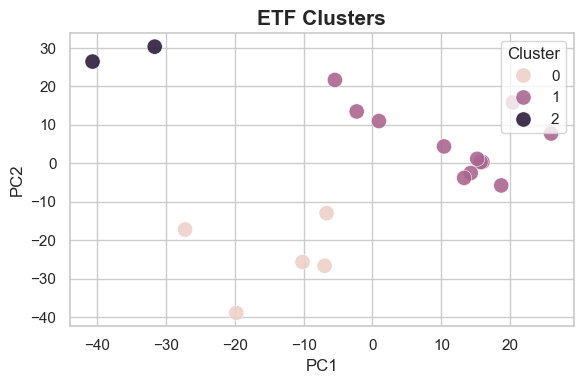

In [ ]:
# k-means / PCA


scaler = StandardScaler()
returns_scaled = scaler.fit_transform(new_returns.T)

pca = PCA(n_components = 2)
pca_components = pca.fit_transform(returns_scaled)

max_clusters = min(len(etfs) - 1, 10)

best_k = 3
best_score = -1

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(pca_components)
    score = silhouette_score(pca_components, labels)

    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters = best_k, random_state = 42)
labels = kmeans.fit_predict(pca_components)

cluster_df = pd.DataFrame({
    'ETF': new_returns.columns,
    'Cluster': labels,
    'PC1': pca_components[:, 0],
    'PC2': pca_components[:, 1]
})

print(f'Clusters:')
print(cluster_df)

sns.set_theme(style = 'whitegrid', font_scale = 1)

plt.figure(figsize = (6, 4))

sns.scatterplot(
    data = cluster_df,
    x = 'PC1',        
    y = 'PC2',
    hue = 'Cluster',
    s = 120, 
    linewidth = 0.4,
    alpha = 0.9 
)

plt.title(f'ETF Clusters', fontsize = 15, weight = 'bold')
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

plt.legend(title = 'Cluster', loc='upper right', frameon = True)

plt.tight_layout()
plt.show()

cluster_df = cluster_df.sort_values(by = 'Cluster')

In [ ]:
final_candidates = []

cluster_zip = dict(zip(cluster_df['ETF'], cluster_df['Cluster']))

for _, row in corr_filtered_pairs_df.iterrows():
    etf1, etf2, pass_percentage = row['ETF1'], row['ETF2'], row['Pass %']
    if cluster_zip[etf1] == cluster_zip[etf2]:
        final_candidates.append([etf1, etf2, pass_percentage, cluster_zip[etf1]])

final_candidates = pd.DataFrame(final_candidates, columns=['ETF1','ETF2','RC Pass %','Cluster #'])
final_candidates = final_candidates.sort_values('RC Pass %', ascending=False).reset_index(drop=True)
print(final_candidates)


   ETF1  ETF2  RC Pass %  Cluster #
0  SCHV  SPHQ   0.479167          1
1   VTV  SPHQ   0.437500          1
2   IWS   IJH   0.437500          0
3   DVY   FVD   0.416667          2
